In [1]:
from pathlib import Path
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans
import umap.umap_ as umap
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import faiss
from mpl_toolkits.mplot3d import Axes3D
import random
from networkx.algorithms.community import greedy_modularity_communities, modularity

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def read_fvecs(filename):
    """Load .fvecs file (float32 vectors)."""
    with open(filename, 'rb') as f:
        return np.fromfile(f, dtype=np.float32).reshape(-1, 129)[:, 1:]


def read_ivecs(fname):
    """
    Reads an .ivecs file containing int32 vectors.
    Each vector is stored as: [int32 length][int32 elements...]
    """
    a = np.fromfile(fname, dtype=np.int32)
    dim = a[0]
    return a.reshape(-1, dim + 1)[:, 1:]

In [13]:
def plot_pca_scree(X, n_components=128, label='Dataset'):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(cumulative_variance, marker='o', label=label)
    plt.axhline(0.9, color='r', linestyle='--', label='90% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Scree Plot')
    plt.grid(True)
    plt.legend()

In [14]:
def plot_t_sne_scatter(X, path, labels=None, perplexity=30, n_components=2, title='t-SNE Scatter Plot'):
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    X_embedded = tsne.fit_transform(X)

    if labels is not None:
        fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=labels)
    else:
        fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1])

    fig.update_layout(title=title)

    
    fig.write_image(path)
    fig.show()

In [15]:
def plot_umap(X, path, labels=None, n_neighbors=15, min_dist=0.1, n_components=2, title='UMAP Projection'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    X_embedded = reducer.fit_transform(X)

    if labels is not None:
        fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=labels)
    else:
        fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1])

    fig.update_layout(title=title)
    fig.write_image(path)
    fig.show()

In [16]:
def plot_t_sne_3d(X, path, labels=None, perplexity=30, title='t-SNE 3D Scatter Plot'):
    tsne = TSNE(n_components=3, perplexity=perplexity)
    X_embedded = tsne.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if labels is not None:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=labels, cmap='viridis',  s=1, alpha=0.6)
        plt.colorbar(scatter)
    else:
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], s=1, alpha=0.6)

    ax.set_title(title)
    plt.savefig(path)
    plt.show()

In [17]:
def plot_umap_3d(X,path, labels=None, n_neighbors=15, min_dist=0.1, title='UMAP 3D Projection'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=3)
    X_embedded = reducer.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if labels is not None:
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=labels, cmap='viridis')
        plt.colorbar(scatter)
    else:
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2])

    ax.set_title(title)
    plt.savefig(path)
    plt.show()

In [18]:
def plot_knn_graph(X,path, n_neighbors=10, title='KNN Graph'):
    knn_graph = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_matrix(knn_graph)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False)
    plt.title(title)
    plt.savefig(path)
    plt.show()

In [19]:
def plot_knn_graph_faiss(X,path, k=10, title='KNN Graph with FAISS'):
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    D, I = index.search(X, k)

    G = nx.Graph()
    for i in range(len(X)):
        for j in range(1, k):
            G.add_edge(i, I[i][j], weight=D[i][j])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False)
    plt.title(title)
    plt.savefig(path)
    plt.show()

In [20]:
def plot_distance_nn_histogram(X, queries, path, k=10, title='Distance to Nearest Neighbors Histogram'):
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    D, I = index.search(queries, k)

    plt.hist(D[:, 0], bins=50)
    plt.title(title)
    plt.xlabel('L2 Distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(path)
    plt.show()

In [21]:
def plot_kmeans_clusters(k, X, path, d):
    kmeans = faiss.Kmeans(d=d, k=k, niter=20, verbose=True)
    kmeans.train(X)
    _, cluster_ids = kmeans.index.search(X, 1)

    # Optional: visualize some cluster centers or plot their norms
    norms = np.linalg.norm(kmeans.centroids, axis=1)
    plt.hist(norms, bins=30)
    plt.title('Norms of Cluster Centers')
    plt.xlabel('Norm')
    plt.ylabel('Count')
    plt.savefig(path)
    plt.show()

In [22]:
def calc_mean_overlap(X, k):
    """Calculate mean overlap of neighbors."""
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = nbrs.kneighbors(X)  # include self at index 0
    neighbors = ind[:,1:]          # drop self
    overlaps = []
    for i in tqdm(range(len(X))):
        Ni = set(neighbors[i])
        for j in neighbors[i]:
            Nj = set(neighbors[j])
            overlaps.append(len(Ni & Nj))
    return np.mean(overlaps)



In [23]:
def get_modularity_and_communities(X, k):
    """Calculate modularity and communities for a k-NN graph."""
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, idx = nbrs.kneighbors(X)
    adj = np.zeros((len(X), len(X)), dtype=int)
    for i in range(len(X)):
        for j in idx[i, 1:]:
            adj[i, j] = 1
            adj[j, i] = 1

    G = nx.from_numpy_array(adj)
    communities = list(greedy_modularity_communities(G))
    mod_value = modularity(G, communities)
    return mod_value, communities



def plot_modularity_vs_k(X, path, k_values):
    modularities = []
    for k in k_values:
        mod_value, _ = get_modularity_and_communities(X, k)
        modularities.append(mod_value)
    plt.plot(k_values, modularities)
    plt.xlabel('k')
    plt.ylabel('Modularity')
    plt.title('Modularity vs k')
    plt.grid(True)
    plt.savefig(path)
    plt.show()




In [24]:
# # Build k-NN graph (e.g. k=10) on a sample of data
# k = 10
# nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X[:2000])
# dists, idx = nbrs.kneighbors(X[:2000])
# adj = np.zeros((2000,2000), dtype=int)
# for i in range(2000):
#     for j in idx[i,1:]:  # skip self (index 0)
#         adj[i,j] = 1; adj[j,i] = 1

# G = nx.from_numpy_array(adj)
# # Find communities by greedy modularity optimization
# communities = list(greedy_modularity_communities(G))
# mod_value = modularity(G, communities)
# print("Graph modularity:", mod_value)


# # Reorder adjacency for heatmap
# labels = np.zeros(2000, dtype=int)
# for cid, comm in enumerate(communities):
#     for v in comm: labels[v] = cid
# order = np.argsort(labels)
# adj_ordered = adj[order][:,order]
# plt.figure(figsize=(4,4))
# plt.imshow(adj_ordered, cmap='Greys', interpolation='nearest')
# plt.title('k-NN adjacency (sorted by community)')
# plt.xlabel('Node index (sorted)')
# plt.ylabel('Node index (sorted)')
# plt.tight_layout()
# plt.savefig('knn_heatmap.png')

def plot_knn_heatmap(X, path, k=10, title='KNN Heatmap'):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    dists, idx = nbrs.kneighbors(X)
    adj = np.zeros((len(X), len(X)), dtype=int)
    for i in range(len(X)):
        for j in idx[i, 1:]:
            adj[i, j] = 1
            adj[j, i] = 1

    G = nx.from_numpy_array(adj)
    communities = list(greedy_modularity_communities(G))
    labels = np.zeros(len(X), dtype=int)
    for cid, comm in enumerate(communities):
        for v in comm:
            labels[v] = cid
    order = np.argsort(labels)
    adj_ordered = adj[order][:, order]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(adj_ordered, cmap='Greys', interpolation='nearest')
    plt.title(title)
    plt.xlabel('Node index (sorted)')
    plt.ylabel('Node index (sorted)')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()


In [25]:
def compute_shortest_path_length(G):
    """Compute average shortest-path length for a graph."""
    lengths = []
    for node in random.sample(list(G.nodes()), 50):
        sp = nx.single_source_shortest_path_length(G, node)
        lengths.extend(list(sp.values()))
    avg_path = np.mean(lengths)
    return avg_path

In [8]:
save_dir = Path('plots')

## Uniform Data Generation

In [5]:
# Uniform data generation
uniform_data = np.random.rand(1000000, 128).astype(np.float32)
uniform_data_sample = uniform_data[:10000]

In [18]:
# Plot 2D t-SNE plot
plot_t_sne_scatter(uniform_data_sample, save_dir / 'uniform_t_sne_2d.png', perplexity=30, title='Uniform Data t-SNE')

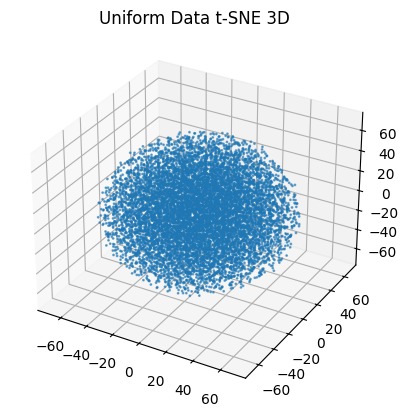

In [19]:
# Plot 3D t-SNE plot
plot_t_sne_3d(uniform_data_sample, save_dir / 'uniform_t_sne_3d.png', title='Uniform Data t-SNE 3D')

In [20]:
# 2D UMAP Plot
plot_umap(uniform_data_sample, save_dir / 'uniform_umap_2d.png', title='Uniform Data UMAP')

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



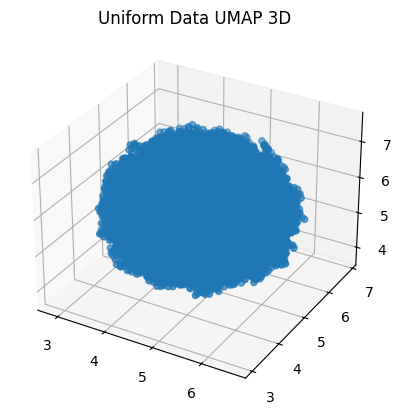

In [21]:
# 3D UMAP Plot
plot_umap_3d(uniform_data_sample, save_dir / 'uniform_umap_3d.png', title='Uniform Data UMAP 3D')

In [22]:
# Fit UMAP to 3D
umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
uniform_umap_3d = umap_3d.fit_transform(uniform_data_sample)

# Plotly 3D scatter
fig = px.scatter_3d(
    x=uniform_umap_3d[:, 0], y=uniform_umap_3d[:, 1], z=uniform_umap_3d[:, 2],
    opacity=0.6,
    title="UMAP 3D Projection of Uniform data (10K)",
)
fig.update_traces(marker=dict(size=2))
fig.show()


/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



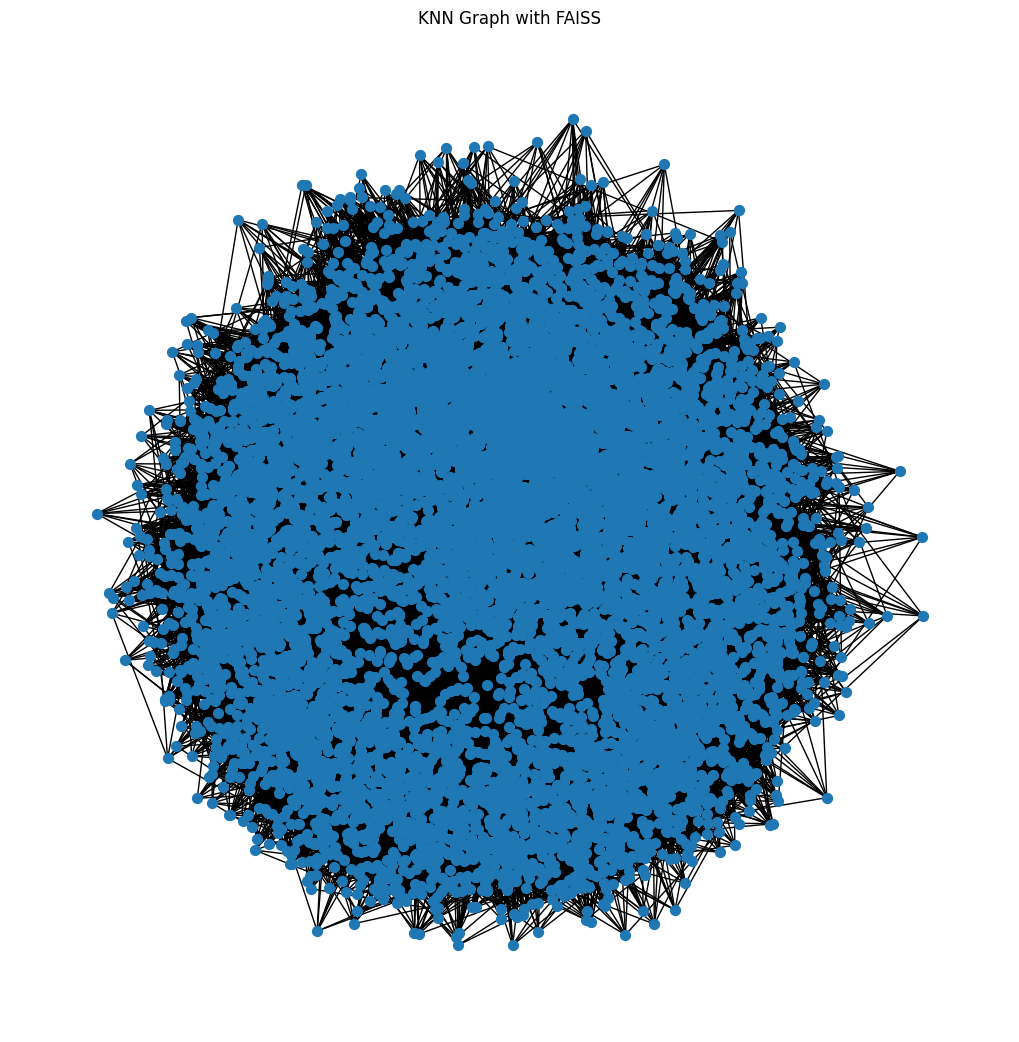

In [23]:
# KNN Graph with faiss
plot_knn_graph_faiss(uniform_data_sample, save_dir / 'uniform_knn_graph_faiss.png', k=10, title='KNN Graph with FAISS')

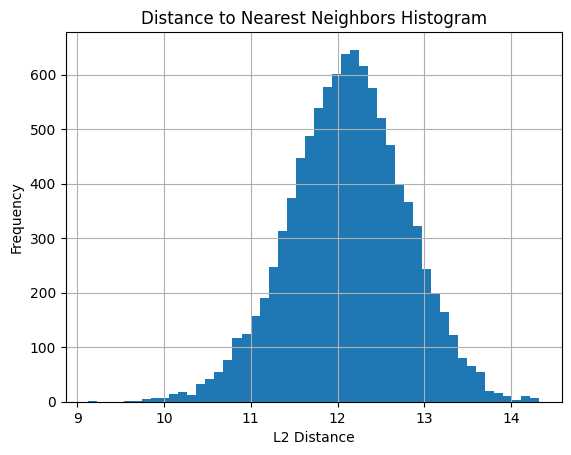

In [28]:
#Plot histogram
unifrom_queries = np.random.rand(10000, 128).astype(np.float32)
plot_distance_nn_histogram(uniform_data, unifrom_queries, save_dir / 'uniform_distance_nn_histogram.png', k=10, title='Distance to Nearest Neighbors Histogram')

Sampling a subset of 2560 / 1000000 for training
Clustering 2560 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.27 s
  Iteration 19 (0.07 s, search 0.04 s): objective=26421.5 imbalance=1.012 nsplit=0       


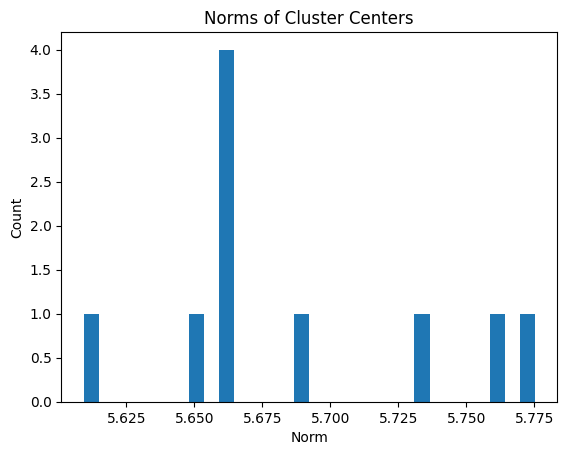

In [29]:
# Plot K-Means clusters
plot_kmeans_clusters(10, uniform_data, save_dir / 'uniform_kmeans_clusters.png', d=128)

In [6]:
# Calculate mean overlap
mean_overlap = calc_mean_overlap(uniform_data_sample, k=10)
print(f'Mean overlap for uniform data: {mean_overlap}')

100%|██████████| 10000/10000 [00:00<00:00, 19491.89it/s]

Mean overlap for uniform data: 0.17501


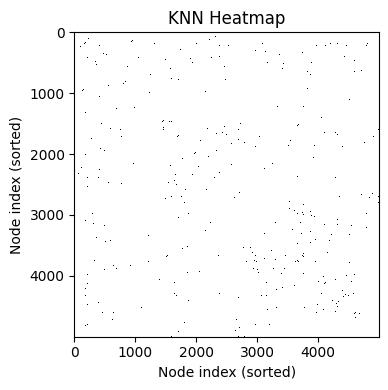

In [10]:
# Plot KNN heatmap
uniform_data_sample_5k = uniform_data[:5000]
plot_knn_heatmap(uniform_data_sample_5k, save_dir / 'uniform_knn_heatmap.png', k=10, title='KNN Heatmap')

In [27]:
# Compute average shortest-path length
G = nx.from_numpy_array(kneighbors_graph(uniform_data_sample, n_neighbors=10).toarray())
avg_path_length = compute_shortest_path_length(G)
print(f'Average shortest-path length for uniform data: {avg_path_length}')

Average shortest-path length for uniform data: 3.48088


## SIFT Dataset

In [30]:
# Read SIFT Data
data_path = Path('./data/sift/')
X = read_fvecs(data_path / 'sift_base.fvecs')
X_sample = X[np.random.choice(X.shape[0], 10000, replace=False)]
queries = read_fvecs(data_path / 'sift_query.fvecs')

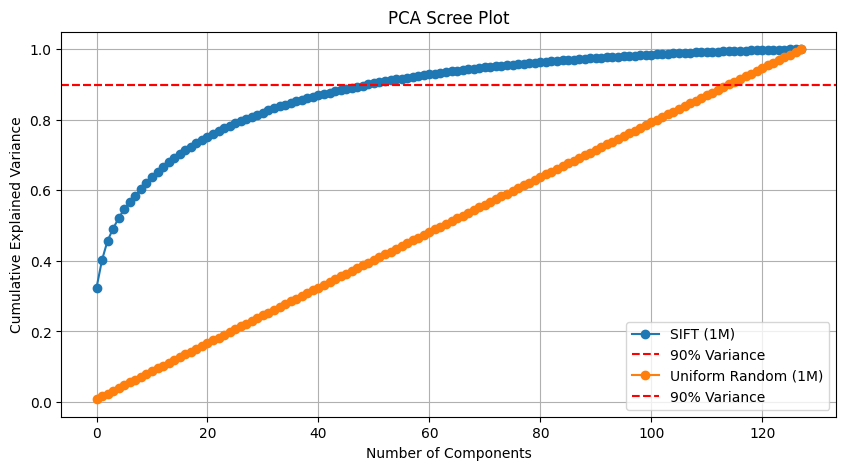

In [79]:
# PCA Scree plot
plt.figure(figsize=(10, 5))
plot_pca_scree(X, label='SIFT (1M)')
plot_pca_scree(uniform_data, label='Uniform Random (1M)')
plt.savefig(str(save_dir / 'sift_pca_scree.png'))
plt.show()
#Save image



In [80]:
# 2D t-SNE plot
img_path = save_dir / 'sift_t_sne_2d.png'
plot_t_sne_scatter(X_sample, img_path, perplexity=30, title='t-SNE 2D SIFT')


<Figure size 1000x500 with 0 Axes>

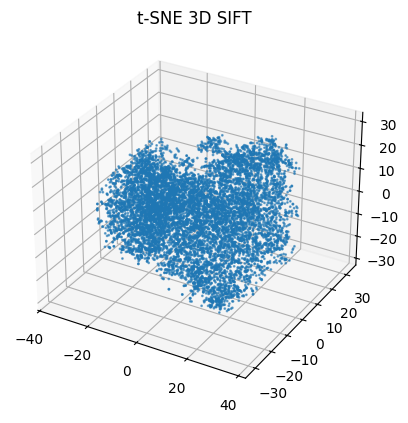

In [81]:
#3D t-SNE plot
# X_sample = X[np.random.choice(X.shape[0], 15000, replace=False)]
plot_t_sne_3d(X_sample, save_dir / 'sift_t_sne_3d.png', perplexity=30, title='t-SNE 3D SIFT')

In [82]:
#2D UMAP plot
img_path = save_dir / 'sift_umap_2d.png'
plot_umap(X_sample, img_path, n_neighbors=15, min_dist=0.1, title='UMAP 2D SIFT')

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



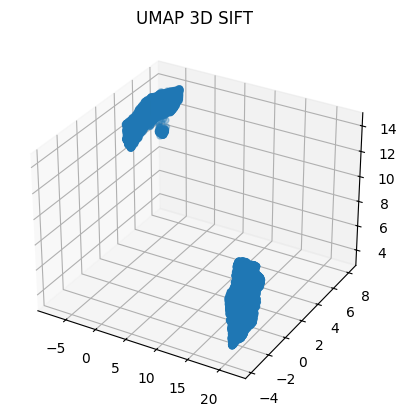

In [83]:
# 3D UMAP plot
# X_sample = X[np.random.choice(X.shape[0], 15000, replace=False)]
plot_umap_3d(X_sample, save_dir / 'sift_umap_3d.png', n_neighbors=15, min_dist=0.1, title='UMAP 3D SIFT')

In [84]:
# Fit UMAP to 3D
umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_sample)

# Plotly 3D scatter
fig = px.scatter_3d(
    x=X_umap_3d[:, 0], y=X_umap_3d[:, 1], z=X_umap_3d[:, 2],
    opacity=0.6,
    title="UMAP 3D Projection of SIFT Sample (10K)",
)
fig.update_traces(marker=dict(size=2))
fig.show()


/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/harshamupparaju/Softwares/anaconda3/envs/amlds_project/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



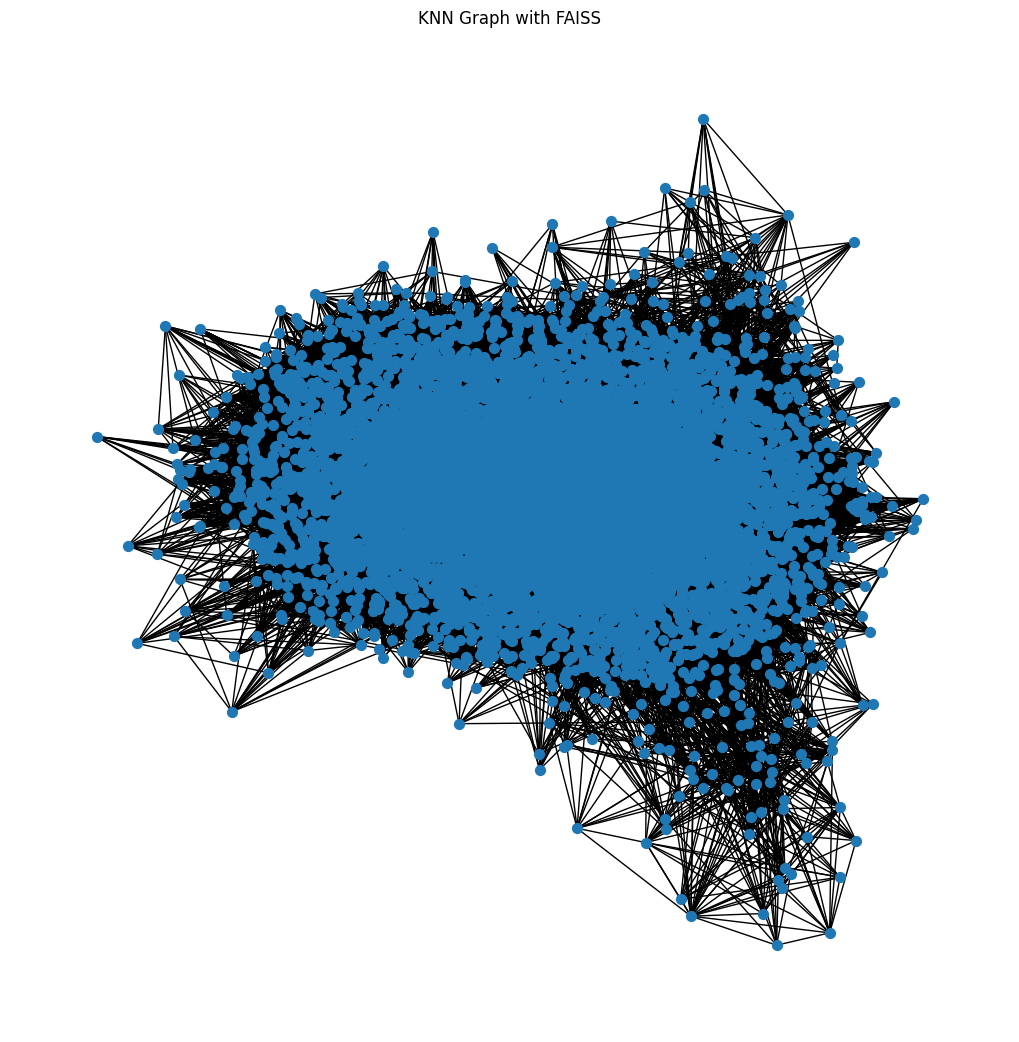

In [85]:
# KNN Graph
img_path = save_dir / 'sift_knn_graph.png'
plot_knn_graph_faiss(X_sample, img_path, k=10, title='KNN Graph with FAISS')



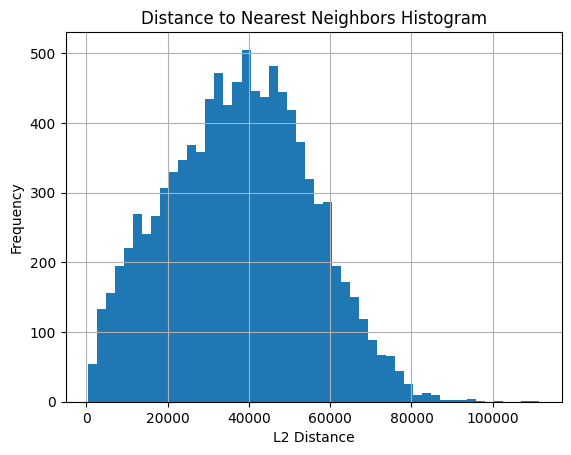

In [86]:
# Plot distance histogram
img_path = save_dir / 'sift_distance_histogram.png'
plot_distance_nn_histogram(X, queries, img_path, k=10, title='Distance to Nearest Neighbors Histogram')

Sampling a subset of 25600 / 1000000 for training
Clustering 25600 points in 128D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.09 s
  Iteration 19 (0.30 s, search 0.27 s): objective=1.60855e+09 imbalance=1.092 nsplit=0       


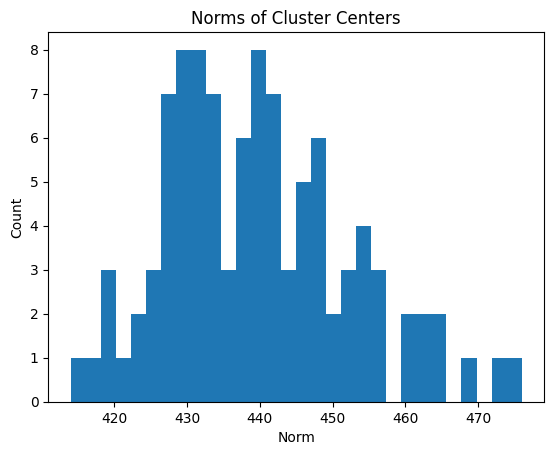

In [87]:
#Plot KMeans clusters
img_path = save_dir / 'sift_kmeans_clusters.png'
plot_kmeans_clusters(100, X, img_path, d=128)

In [88]:
# Calculate mean overlap
mean_overlap = calc_mean_overlap(X_sample, 10)
print(f'Mean overlap for k=10: {mean_overlap}')

100%|██████████| 10000/10000 [00:00<00:00, 32628.56it/s]


In [89]:
# Print mean overlap


Mean overlap for k=10: 1.68314


In [90]:
# # Calculate modularity and communities
# modularity_values = []
# communities_list = []
# k_values = range(10, 101, 10)
# for k in tqdm(k_values):
#     mod_value, communities = get_modularity_and_communities(X_sample, k)
#     modularity_values.append(mod_value)
#     communities_list.append(communities)

# # Plot modularity vs k
# img_path = save_dir / 'sift_modularity_vs_k.png'
# plot_modularity_vs_k(X_sample, img_path, k_values)


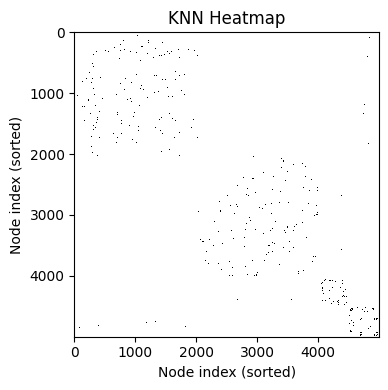

In [31]:
# Plot KNN heatmap
img_path = save_dir / 'sift_knn_heatmap.png'
X_sample_5k = X_sample[:5000]
plot_knn_heatmap(X_sample_5k, img_path, k=10, title='KNN Heatmap')

In [33]:
# Compute average shortest path length
G = nx.from_numpy_array(kneighbors_graph(X_sample, n_neighbors=10, mode='connectivity').toarray())
avg_path_length = compute_shortest_path_length(G)
print(f'Average shortest-path length for SIFT data: {avg_path_length}')

Average shortest-path length for SIFT data: 5.989722


## DEEP

## GloVE